# Lab2 Objective:

Apply transfer learning to classify a given sample image by using transfer learning using a pre-trained InceptionV3 network available in the Keras library.

In [2]:
#import the pre-trained InceptionV3 library
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions

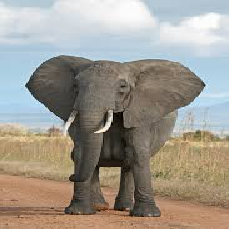

In [ ]:
#load the image
image = load_img('./sample_image.jpg',target_size=(229,229,3))
display(image)

In [ ]:
#convert a image pixels to a numpy array
image = img_to_array(image)
#reshape the data for the model
image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
#prepare the image for the InceptionV3 model
image = preprocess_input(image)

## Using the inceptionV3 model to classcify directly

In [ ]:
#load the model
model = InceptionV3()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
#make prediction
pred = model.predict(image)
#convert to labels
label = decode_predictions(pred)
#retrieve the most likely result
label = label[0][0]
print(label[1], label[2]*100)

African_elephant 99.14223551750183


## Fine-tune InceptionV3 on a new set of classes

In [11]:
#load model without classfier layer
base_model = InceptionV3(include_top=False)

# Freeze all feature extracting layers
for layers in base_model.layers:
    layers.trainable = False

In [12]:
from keras.layers import Flatten
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model
# add a global spatial average pooling layer
avgpooling= GlobalAveragePooling2D()(base_model.output)
# add a fully-connected layer
fullyconnect = Dense(1024, activation='relu')(avgpooling)
# and a logistic layer -- let's say we have 5 classes
predictions = Dense(5, activation='softmax')(fullyconnect)

#build a new model
model_new = Model(inputs=base_model.input, outputs=predictions)

model_new.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [13]:
#compile the model
model_new.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

In [14]:
#load the new dataset
import os
import os
from google.colab import drive
from tqdm import tqdm

drive.mount('/content/drive')
path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)
data_dir = 'Colab Notebooks/Animal-10'
dirs = os.listdir(data_dir)
X, Y = [], []
for dir in dirs:
    folder_dir = os.path.join(data_dir, dir)
    for img in tqdm(os.listdir(folder_dir)):
        path = os.path.join(folder_dir, img)
        X.append(path)
        Y.append(str(dir))

100%|██████████| 2623/2623 [00:00<00:00, 490685.49it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
#split the dataset to train and validation
#As the dataset is big, i only load 5 classes of the dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, DirectoryIterator
batch_size = 32
generator = ImageDataGenerator(
    validation_split=0.3,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_set = generator.flow_from_directory(
    data_dir,
    target_size=(229, 229),
    batch_size=batch_size,
    subset='training') 

validation_set = generator.flow_from_directory(
    data_dir, 
    target_size=(229, 229),
    batch_size=batch_size,
    subset='validation')

Found 9903 images belonging to 5 classes.
Found 4239 images belonging to 5 classes.


In [16]:
#training the new dataset
history = model_new.fit(train_set, epochs=3, validation_data=validation_set)

Epoch 1/3
310/310 [==============================] - 380s 1s/step - loss: 0.4002 - accuracy: 0.9103 - val_loss: 0.0823 - val_accuracy: 0.9764
Epoch 2/3
310/310 [==============================] - 178s 573ms/step - loss: 0.0600 - accuracy: 0.9803 - val_loss: 0.0551 - val_accuracy: 0.9828
Epoch 3/3
310/310 [==============================] - 177s 570ms/step - loss: 0.0556 - accuracy: 0.9817 - val_loss: 0.0789 - val_accuracy: 0.9785


In [17]:
model_new.save('transfer_InceptionV3.md')

INFO:tensorflow:Assets written to: transfer_InceptionV3.md/assets


## predict the sample image using the new model

In [30]:
import cv2
image = cv2.imread('Colab Notebooks/sample_image.jpg', cv2.IMREAD_COLOR)
array = cv2.resize(image, (229, 229))
array = array / 255
array.shape
#reshape the data for the model
image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))

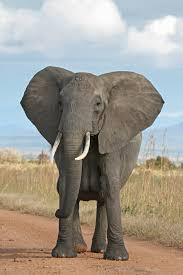

In [24]:
load_img('Colab Notebooks/sample_image.jpg')

In [37]:
import numpy as np
#predict
label = np.argmax(model_new.predict(image), axis=-1)
#convert to classes
print(f'The picture is: {dirs[label[0]]}')

The picture is: elefante
